In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
import math
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import layers, activations
from scipy.interpolate import griddata

In [2]:
def dot(a, b):
  """Dot product function since TensorFlow doesn't have one."""
  return tf.reduce_sum(a*b)

def verbose_func(s):
  print(s)

final_loss = None
times = []
def lbfgs(opfunc, x, state, maxIter = 100, learningRate = 1, do_verbose = True):
  """port of lbfgs.lua, using TensorFlow eager mode.
  """

  global final_loss, times

  maxEval = maxIter*1.25
  tolFun = 1e-5
  tolX = 1e-9
  nCorrection = 50
  isverbose = False

  # verbose function
  if isverbose:
    verbose = verbose_func
  else:
    verbose = lambda x: None

  f, g = opfunc(x)

  f_hist = [f]
  currentFuncEval = 1
  state.funcEval = state.funcEval + 1
  p = g.shape[0]

  # check optimality of initial point
  tmp1 = tf.abs(g)
  if tf.reduce_sum(tmp1) <= tolFun:
    verbose("optimality condition below tolFun")
    return x, f_hist

  # optimize for a max of maxIter iterations
  nIter = 0
  times = []
  while nIter < maxIter:
    start_time = time.time()

    # keep track of nb of iterations
    nIter = nIter + 1
    state.nIter = state.nIter + 1

    ############################################################
    ## compute gradient descent direction
    ############################################################
    if state.nIter == 1:
      d = -g
      old_dirs = []
      old_stps = []
      Hdiag = 1
    else:
      # do lbfgs update (update memory)
      y = g - g_old
      s = d*t
      ys = dot(y, s)

      if ys > 1e-10:
        # updating memory
        if len(old_dirs) == nCorrection:
          # shift history by one (limited-memory)
          del old_dirs[0]
          del old_stps[0]

        # store new direction/step
        old_dirs.append(s)
        old_stps.append(y)

        # update scale of initial Hessian approximation
        Hdiag = ys/dot(y, y)

      # compute the approximate (L-BFGS) inverse Hessian
      # multiplied by the gradient
      k = len(old_dirs)

      # need to be accessed element-by-element, so don't re-type tensor:
      ro = [0]*nCorrection
      for i in range(k):
        ro[i] = 1/dot(old_stps[i], old_dirs[i])


      # iteration in L-BFGS loop collapsed to use just one buffer
      # need to be accessed element-by-element, so don't re-type tensor:
      al = [0]*nCorrection

      q = -g
      for i in range(k-1, -1, -1):
        al[i] = dot(old_dirs[i], q) * ro[i]
        q = q - al[i]*old_stps[i]

      # multiply by initial Hessian
      r = q*Hdiag
      for i in range(k):
        be_i = dot(old_stps[i], r) * ro[i]
        r += (al[i]-be_i)*old_dirs[i]

      d = r
      # final direction is in r/d (same object)

    g_old = g
    f_old = f

    ############################################################
    ## compute step length
    ############################################################
    # directional derivative
    gtd = dot(g, d)

    # check that progress can be made along that direction
    if gtd > -tolX:
      verbose("Can not make progress along direction.")
      break

    # reset initial guess for step size
    if state.nIter == 1:
      tmp1 = tf.abs(g)
      t = min(1, 1/tf.reduce_sum(tmp1))
    else:
      t = learningRate



    x += t*d

    if nIter != maxIter:
    # re-evaluate function only if not in last iteration
    # the reason we do this: in a stochastic setting,
    # no use to re-evaluate that function here
      f, g = opfunc(x)

    lsFuncEval = 1
    f_hist.append(f)


    # update func eval
    currentFuncEval = currentFuncEval + lsFuncEval
    state.funcEval = state.funcEval + lsFuncEval

    ############################################################
    ## check conditions
    ############################################################
    if nIter == maxIter:
      break

    if currentFuncEval >= maxEval:
      # max nb of function evals
      print('max nb of function evals')
      break

    tmp1 = tf.abs(g)
    if tf.reduce_sum(tmp1) <=tolFun:
      # check optimality
      print('optimality condition below tolFun')
      break

    tmp1 = tf.abs(d*t)
    if tf.reduce_sum(tmp1) <= tolX:
      # step size below tolX
      print('step size below tolX')
      break

    if tf.abs(f,f_old) < tolX:
      # function value changing less than tolX
      print('function value changing less than tolX'+str(tf.abs(f-f_old)))
      break

    if do_verbose:
      if nIter % 10 == 0:
        print("Step %3d loss %6.5f "%(nIter, f.numpy()))


    if nIter == maxIter - 1:
      final_loss = f.numpy()


  # save state
  state.old_dirs = old_dirs
  state.old_stps = old_stps
  state.Hdiag = Hdiag
  state.g_old = g_old
  state.f_old = f_old
  state.t = t
  state.d = d

  return x, f_hist, currentFuncEval

# dummy/Struct gives Lua-like struct object with 0 defaults
class dummy(object):
  pass

class Struct(dummy):
  def __getattribute__(self, key):
    if key == '__dict__':
      return super(dummy, self).__getattribute__('__dict__')
    return self.__dict__.get(key, 0)


In [13]:

layer_sizes = [2,20,20,20, 1]

sizes_w = []
sizes_b = []
for i, width in enumerate(layer_sizes):
    if i != 1:
        sizes_w.append(int(width * layer_sizes[1]))
        sizes_b.append(int(width if i != 0 else layer_sizes[1]))

def set_weights(model, w, sizes_w, sizes_b):
        for i, layer in enumerate(model.layers[0:]):
            start_weights = sum(sizes_w[:i]) + sum(sizes_b[:i])
            end_weights = sum(sizes_w[:i+1]) + sum(sizes_b[:i])
            weights = w[start_weights:end_weights]
            w_div = int(sizes_w[i] / sizes_b[i])
            weights = tf.reshape(weights, [w_div, sizes_b[i]])
            biases = w[end_weights:end_weights + sizes_b[i]]
            weights_biases = [weights, biases]
            layer.set_weights(weights_biases)



def get_weights(model):
        w = []
        for layer in model.layers[0:]:
            weights_biases = layer.get_weights()
            weights = weights_biases[0].flatten()
            biases = weights_biases[1]
            w.extend(weights)
            w.extend(biases)

        w = tf.convert_to_tensor(w)
        return w


def neural_net(layer_sizes):
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(layer_sizes[0],)))
    for width in layer_sizes[1:-1]:
        model.add(layers.Dense(
            width, activation=tf.nn.tanh,
            kernel_initializer="glorot_normal"))
    model.add(layers.Dense(
            layer_sizes[-1], activation=None,
            kernel_initializer="glorot_normal"))
    return model




In [14]:
def loss(x_f_batch, t_f_batch,
             x0, t0, u0, x_lb,
             t_lb, x_ub, t_ub, col_weights, u_weights):

    f_u_pred = f_model(x_f_batch, t_f_batch)
    u0_pred = u_model(tf.concat([x0, t0],1))
    u_lb_pred, _ = u_x_model(x_lb, t_lb)
    u_ub_pred, _ = u_x_model(x_ub, t_ub)

    mse_0_u = tf.reduce_mean(tf.square(u_weights*(u0 - u0_pred)))

    mse_b_u = tf.reduce_mean(tf.square(u_lb_pred - 0)) + \
            tf.reduce_mean(tf.square(u_ub_pred - 0)) #since ub/lb is 0

    mse_f_u = tf.reduce_mean(tf.square(col_weights*f_u_pred))


    return  mse_0_u + mse_b_u + mse_f_u , mse_0_u,mse_b_u, mse_f_u


@tf.function
def f_model(x,t):
    u = u_model(tf.concat([x,t], 1))
    u_x = tf.gradients(u,x)
    u_xx = tf.gradients(u_x, x)
    u_t = tf.gradients(u,t)
    f_u = u_t + u*u_x - (0.01/tf.constant(math.pi))*u_xx
    return f_u



@tf.function
def u_x_model(x,t):
    u = u_model(tf.concat([x,t],1))
    u_x = tf.gradients(u,x)
    return u,u_x

@tf.function
def grad(model, x_f_batch, t_f_batch, x0_batch, t0_batch, u0_batch, x_lb, t_lb, x_ub, t_ub, col_weights, u_weights):
    with tf.GradientTape(persistent=True) as tape:
        #tape.watch(col_weights)
        #tape.watch(u_weights)
        loss_value, mse_0,mse_b, mse_f = loss(x_f_batch, t_f_batch, x0_batch, t0_batch, u0_batch, x_lb, t_lb, x_ub, t_ub, col_weights, u_weights)
        grads = tape.gradient(loss_value, u_model.trainable_variables)
        #print(grads)
        grads_col = tape.gradient(loss_value, col_weights)
        grads_u = tape.gradient(loss_value, u_weights)

    return loss_value, mse_0,mse_f, grads, grads_col, grads_u

def fit(x_f, t_f, x0, t0, u0, x_lb, t_lb, x_ub, t_ub, col_weights, u_weights, tf_iter, newton_iter):
    # Built in support for mini-batch, set to N_f (i.e. full batch) by default
    batch_sz = N_f
    n_batches =  N_f // batch_sz
    start_time = time.time()
    tf_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005, beta_1=.90)
    tf_optimizer_coll = tf.keras.optimizers.Adam(learning_rate = 0.005, beta_1=.90)
    tf_optimizer_u = tf.keras.optimizers.Adam(learning_rate = 0.005, beta_1=.90)

    print("starting Adam training")

    for epoch in range(tf_iter):
        for i in range(n_batches):

            x0_batch = x0#[i*batch_sz:(i*batch_sz + batch_sz),]
            t0_batch = t0#[i*batch_sz:(i*batch_sz + batch_sz),]
            u0_batch = u0#[i*batch_sz:(i*batch_sz + batch_sz),]

            x_f_batch = x_f[i*batch_sz:(i*batch_sz + batch_sz),]
            t_f_batch = t_f[i*batch_sz:(i*batch_sz + batch_sz),]

            loss_value,mse_0,mse_f, grads, grads_col, grads_u = grad(u_model, x_f_batch, t_f_batch, x0_batch, t0_batch, u0_batch, x_lb, t_lb, x_ub, t_ub, col_weights, u_weights)

            tf_optimizer.apply_gradients(zip(grads, u_model.trainable_variables))
            tf_optimizer_coll.apply_gradients(zip([-grads_col], [col_weights]))
            tf_optimizer_u.apply_gradients(zip([-grads_u], [u_weights]))


        if epoch % 50 == 0:
            elapsed = time.time() - start_time
            print('It: %d, Time: %.2f' % (epoch, elapsed))
            tf.print(f"mse_0: {mse_0}  mse_f: {mse_f}   total loss: {loss_value}")
            start_time = time.time()


    #l-bfgs-b optimization
    print("Starting L-BFGS training")

    loss_and_flat_grad = get_loss_and_flat_grad(x_f_batch, t_f_batch, x0_batch, t0_batch, u0_batch, x_lb, t_lb, x_ub, t_ub, col_weights, u_weights)

    lbfgs(loss_and_flat_grad,
      get_weights(u_model),
      Struct(), maxIter=newton_iter, learningRate=0.8)


# L-BFGS implementation from https://github.com/pierremtb/PINNs-TF2.0
def get_loss_and_flat_grad(x_f_batch, t_f_batch, x0_batch, t0_batch, u0_batch, x_lb, t_lb, x_ub, t_ub, col_weights, u_weights):
    def loss_and_flat_grad(w):
        with tf.GradientTape() as tape:
            set_weights(u_model, w, sizes_w, sizes_b)
            loss_value,_, _, _ = loss(x_f_batch, t_f_batch, x0_batch, t0_batch, u0_batch, x_lb, t_lb, x_ub, t_ub, col_weights, u_weights)
        grad = tape.gradient(loss_value, u_model.trainable_variables)
        grad_flat = []
        for g in grad:
            grad_flat.append(tf.reshape(g, [-1]))
        grad_flat = tf.concat(grad_flat, 0)
        #print(loss_value, grad_flat)
        return loss_value, grad_flat

    return loss_and_flat_grad


def predict(X_star):
    X_star = tf.convert_to_tensor(X_star, dtype=tf.float32)
    u_star, _ = u_x_model(X_star[:,0:1],
                     X_star[:,1:2])

    f_u_star = f_model(X_star[:,0:1],
                 X_star[:,1:2])

    return u_star.numpy(), f_u_star.numpy()

In [15]:
pip install pyDOE

In [16]:
from pyDOE import lhs

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
u_model = neural_net(layer_sizes)


lb = np.array([-1.0]) #x lower boundary
ub = np.array([1.0]) #x upper boundary

N0 = 200
N_b = 25 #50 per upper and lower boundary, so 100 total
N_f = 1000

col_weights = tf.Variable(tf.reshape(tf.repeat(100.0, N_f),(N_f, -1)))
u_weights = tf.Variable(tf.random.uniform([N0, 1]))

#load data, from Raissi et. al
data = scipy.io.loadmat('/content/drive/My Drive/Nima.M & Prof.ABBASZADEH/PINN/n1/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = data['usol']
Exact_u = np.real(Exact)


#grab random points off the initial condition
idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x,:]
u0 = tf.cast(Exact_u[idx_x,0:1], dtype = tf.float32)

idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t,:]

# Sample collocation points via LHS
X_f = lb + (ub-lb)*lhs(2, N_f)

x_f = tf.convert_to_tensor(X_f[:,0:1], dtype=tf.float32)
t_f = tf.convert_to_tensor(np.abs(X_f[:,1:2]), dtype=tf.float32)


#generate point vectors for training
X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)

#seperate point vectors
x0 = tf.cast(X0[:,0:1], dtype = tf.float32)
t0 = tf.cast(X0[:,1:2], dtype = tf.float32)

x_lb = tf.convert_to_tensor(X_lb[:,0:1], dtype=tf.float32)
t_lb = tf.convert_to_tensor(X_lb[:,1:2], dtype=tf.float32)

x_ub = tf.convert_to_tensor(X_ub[:,0:1], dtype=tf.float32)
t_ub = tf.convert_to_tensor(X_ub[:,1:2], dtype=tf.float32)

# Begin training, modify 10000/10000 for varying levels of adam/L-BFGS respectively
fit(x_f, t_f, x0, t0, u0, x_lb, t_lb, x_ub, t_ub, col_weights, u_weights, tf_iter = 10000, newton_iter = 10000)

starting Adam training
It: 0, Time: 7.85
mse_0: 0.16145092248916626  mse_f: 22.413970947265625   total loss: 22.658376693725586
It: 50, Time: 5.35
mse_0: 0.036295436322689056  mse_f: 22.52601432800293   total loss: 22.645265579223633
It: 100, Time: 4.99
mse_0: 0.00948040559887886  mse_f: 22.638565063476562   total loss: 22.731000900268555
It: 150, Time: 2.19
mse_0: 0.0011206549825146794  mse_f: 22.751562118530273   total loss: 22.83563804626465
It: 200, Time: 2.20
mse_0: 0.00014412608288694173  mse_f: 22.86498260498047   total loss: 22.948081970214844
It: 250, Time: 2.26
mse_0: 0.00013178915833123028  mse_f: 22.978816986083984   total loss: 23.061904907226562
It: 300, Time: 2.22
mse_0: 0.0001161489199148491  mse_f: 23.093053817749023   total loss: 23.17612648010254
It: 350, Time: 3.17
mse_0: 0.00011402518430259079  mse_f: 23.207727432250977   total loss: 23.290796279907227
It: 400, Time: 2.38
mse_0: 0.0018359487876296043  mse_f: 23.322813034057617   total loss: 23.407604217529297
It: 4

In [20]:

# Set up meshgrid
N = 500
tspace = np.linspace(0, 1, N + 1)
xspace = np.linspace(lb[0], ub[0], N + 1)

X, T = np.meshgrid(xspace,tspace)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

lb = np.array([-1.0, 0.0])
ub = np.array([1.0, 1])


u_pred, f_u_pred = predict(X_star)


U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')


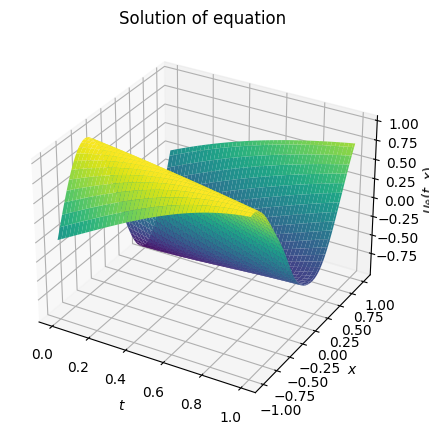

In [21]:
U= U_pred
# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X , U, cmap='viridis');
#ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Solution of equation');

In [23]:
#generate mesh to find U0-pred for the whole domain
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.T.flatten()[:,None]

lb = np.array([-1.0, 0.0])
ub = np.array([1.0, 1])

# Get preds
u_pred, f_u_pred = predict(X_star)

#find L2 error
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))

Error u: 7.367046e-01


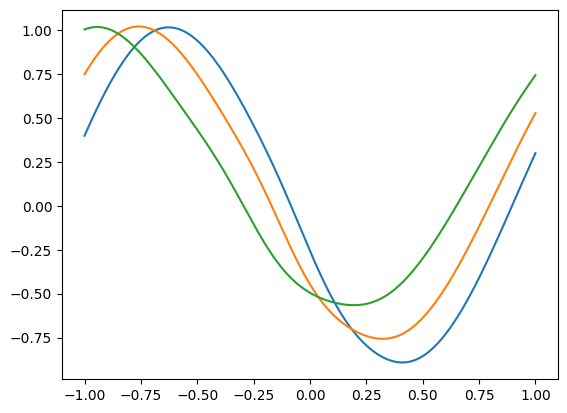

In [22]:
tspace = 0.3
xspace = np.linspace(lb[0], ub[0], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([X.flatten(),T.flatten()]).T
#Xgrid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Determine predictions of u(t, x)
upred,f_u_pred = predict(Xgrid)

# Reshape upred
plt.plot(X,upred)



tspace = 0.6
xspace = np.linspace(lb[0], ub[0], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([X.flatten(),T.flatten()]).T
#Xgrid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Determine predictions of u(t, x)
upred,f_u_pred = predict(Xgrid)

# Reshape upred
plt.plot(X,upred)



tspace = 1.0
xspace = np.linspace(lb[0], ub[0], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([X.flatten(),T.flatten()]).T
#Xgrid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Determine predictions of u(t, x)
upred,f_u_pred = predict(Xgrid)

# Reshape upred
plt.plot(X,upred)